In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms

# Define the transforms to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define the dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

# # Define the device (GPU if available, otherwise CPU)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Files already downloaded and verified


In [54]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

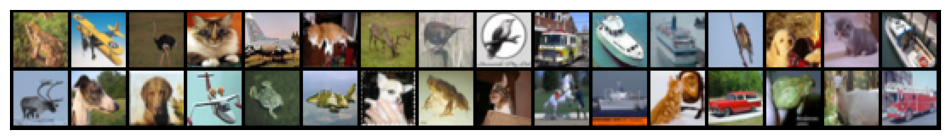

In [55]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(trainloader)

In [56]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

## Model #01

In [82]:
import torch.nn as nn

class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),  # Batch Normalization
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),  # Batch Normalization
            nn.MaxPool2d(2, 2),  # Max Pooling

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),  # Batch Normalization
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),  # Batch Normalization
            nn.MaxPool2d(2, 2),  # Max Pooling

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),  # Batch Normalization
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),  # Batch Normalization
            nn.MaxPool2d(2, 2),  # Max Pooling

            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, xb):
        return self.network(xb)


In [83]:
model = Cifar10CnnModel()

# Count the total number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Total number of parameters: ", total_params)

Total number of parameters:  5853066


In [28]:
for images, labels in trainloader:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([32, 3, 32, 32])
out.shape: torch.Size([32, 10])
out[0]: tensor([ 0.0246,  0.0134, -0.0375, -0.0322, -0.0241, -0.0027, -0.0239,  0.0238,
        -0.0284, -0.0004], grad_fn=<SelectBackward0>)


In [29]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [59]:
device = get_default_device()
device

device(type='cuda')

In [60]:
device = get_default_device()
train_dl = DeviceDataLoader(trainloader, device)
val_dl = DeviceDataLoader(testloader, device)
to_device(model, device);

In [73]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [86]:
model = to_device(Cifar10CnnModel(), device)

In [87]:
evaluate(model, val_dl)

{'val_loss': 2.3028290271759033, 'val_acc': 0.10013977438211441}

In [84]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001

In [88]:
history1 = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.2171, val_loss: 1.0157, val_acc: 0.6431
Epoch [1], train_loss: 0.7336, val_loss: 0.7017, val_acc: 0.7619
Epoch [2], train_loss: 0.5428, val_loss: 0.7339, val_acc: 0.7690
Epoch [3], train_loss: 0.4051, val_loss: 0.5780, val_acc: 0.8185
Epoch [4], train_loss: 0.2953, val_loss: 0.5914, val_acc: 0.8272
Epoch [5], train_loss: 0.2189, val_loss: 0.6841, val_acc: 0.8110
Epoch [6], train_loss: 0.1587, val_loss: 0.7004, val_acc: 0.8256
Epoch [7], train_loss: 0.1302, val_loss: 0.7747, val_acc: 0.8185
Epoch [8], train_loss: 0.1017, val_loss: 0.8144, val_acc: 0.8283
Epoch [9], train_loss: 0.0994, val_loss: 0.8557, val_acc: 0.8266
Epoch [10], train_loss: 0.0875, val_loss: 0.8482, val_acc: 0.8186
Epoch [11], train_loss: 0.0768, val_loss: 0.8603, val_acc: 0.8269
Epoch [12], train_loss: 0.0721, val_loss: 0.9684, val_acc: 0.8293
Epoch [13], train_loss: 0.0676, val_loss: 0.9322, val_acc: 0.8254
Epoch [14], train_loss: 0.0616, val_loss: 0.8792, val_acc: 0.8312
Epoch [15], train_lo

In [66]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

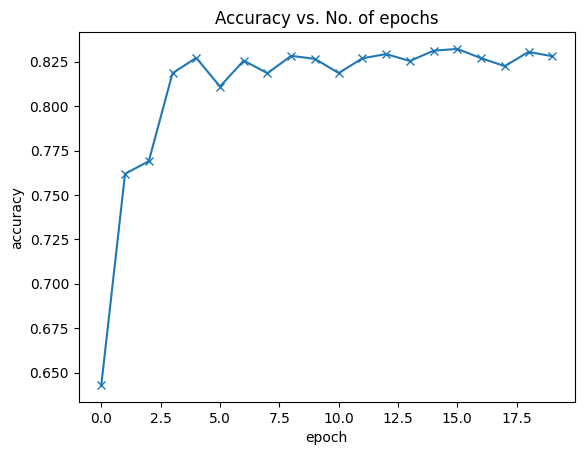

In [89]:
plot_accuracies(history1)

## Model #02

In [90]:
class Cifar10CnnModel2(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, xb):
        return self.network(xb)


Epoch [0], train_loss: 1.1323, val_loss: 0.8807, val_acc: 0.7033
Epoch [1], train_loss: 0.7050, val_loss: 0.7121, val_acc: 0.7611
Epoch [2], train_loss: 0.5371, val_loss: 0.6481, val_acc: 0.7872
Epoch [3], train_loss: 0.4181, val_loss: 0.6080, val_acc: 0.8003
Epoch [4], train_loss: 0.3161, val_loss: 0.6215, val_acc: 0.8108
Epoch [5], train_loss: 0.2372, val_loss: 0.6461, val_acc: 0.8089
Epoch [6], train_loss: 0.1868, val_loss: 0.7802, val_acc: 0.8052
Epoch [7], train_loss: 0.1520, val_loss: 0.7236, val_acc: 0.8220
Epoch [8], train_loss: 0.1277, val_loss: 0.8009, val_acc: 0.8229
Epoch [9], train_loss: 0.1119, val_loss: 0.8169, val_acc: 0.8198
Epoch [10], train_loss: 0.1002, val_loss: 0.8306, val_acc: 0.8187
Epoch [11], train_loss: 0.0845, val_loss: 0.8837, val_acc: 0.8184
Epoch [12], train_loss: 0.0896, val_loss: 0.9089, val_acc: 0.8074
Epoch [13], train_loss: 0.0785, val_loss: 0.9474, val_acc: 0.8196
Epoch [14], train_loss: 0.0726, val_loss: 0.9737, val_acc: 0.8205
Epoch [15], train_lo

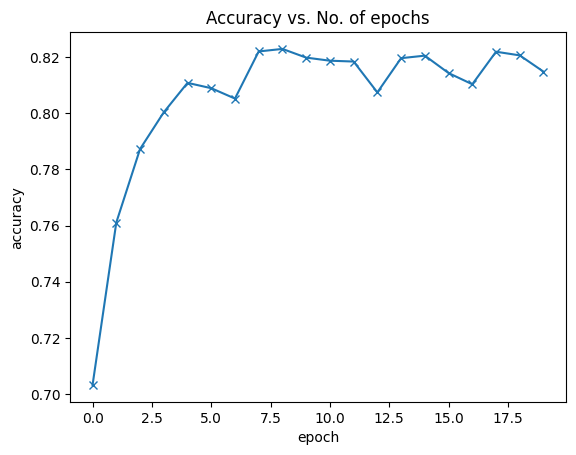

In [91]:
model = to_device(Cifar10CnnModel2(), device)
evaluate(model, val_dl)

num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001

history2 = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)
plot_accuracies(history2)

## Model #03

In [92]:
class Cifar10CnnModel3(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, xb):
        return self.network(xb)


Total number of parameters:  5853066
Epoch [0], train_loss: 1.2617, val_loss: 0.9438, val_acc: 0.6801
Epoch [1], train_loss: 0.7565, val_loss: 0.6791, val_acc: 0.7717
Epoch [2], train_loss: 0.5618, val_loss: 0.6704, val_acc: 0.7806
Epoch [3], train_loss: 0.4212, val_loss: 0.5778, val_acc: 0.8198
Epoch [4], train_loss: 0.3079, val_loss: 0.5615, val_acc: 0.8244
Epoch [5], train_loss: 0.2234, val_loss: 0.6138, val_acc: 0.8223
Epoch [6], train_loss: 0.1735, val_loss: 0.6505, val_acc: 0.8253
Epoch [7], train_loss: 0.1343, val_loss: 0.7280, val_acc: 0.8203
Epoch [8], train_loss: 0.1147, val_loss: 0.8464, val_acc: 0.8225
Epoch [9], train_loss: 0.0970, val_loss: 0.7982, val_acc: 0.8314
Epoch [10], train_loss: 0.0857, val_loss: 0.8377, val_acc: 0.8259
Epoch [11], train_loss: 0.0816, val_loss: 0.8864, val_acc: 0.8292
Epoch [12], train_loss: 0.0760, val_loss: 0.8674, val_acc: 0.8193
Epoch [13], train_loss: 0.0680, val_loss: 0.8828, val_acc: 0.8240
Epoch [14], train_loss: 0.0640, val_loss: 0.9347,

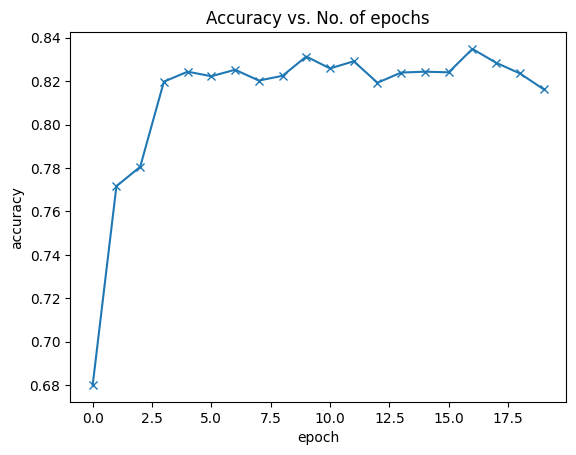

In [94]:
model = to_device(Cifar10CnnModel3(), device)
evaluate(model, val_dl)

# Count the total number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Total number of parameters: ", total_params)

num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001

history3 = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)
plot_accuracies(history3)

## Model #04

In [95]:
class Cifar10CnnModel4(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, xb):
        return self.network(xb)


Total number of parameters:  1465802
Epoch [0], train_loss: 1.1535, val_loss: 0.8458, val_acc: 0.6962
Epoch [1], train_loss: 0.7246, val_loss: 0.6626, val_acc: 0.7690
Epoch [2], train_loss: 0.5489, val_loss: 0.6344, val_acc: 0.7869
Epoch [3], train_loss: 0.4270, val_loss: 0.5952, val_acc: 0.8013
Epoch [4], train_loss: 0.3269, val_loss: 0.6778, val_acc: 0.7936
Epoch [5], train_loss: 0.2446, val_loss: 0.7357, val_acc: 0.7972
Epoch [6], train_loss: 0.1918, val_loss: 0.7161, val_acc: 0.8128
Epoch [7], train_loss: 0.1535, val_loss: 0.7671, val_acc: 0.8152
Epoch [8], train_loss: 0.1345, val_loss: 0.8837, val_acc: 0.8103
Epoch [9], train_loss: 0.1110, val_loss: 0.9283, val_acc: 0.8007
Epoch [10], train_loss: 0.1045, val_loss: 0.9175, val_acc: 0.8127
Epoch [11], train_loss: 0.0895, val_loss: 1.1020, val_acc: 0.8018
Epoch [12], train_loss: 0.0863, val_loss: 1.0051, val_acc: 0.8075
Epoch [13], train_loss: 0.0795, val_loss: 0.9488, val_acc: 0.8100
Epoch [14], train_loss: 0.0775, val_loss: 0.9698,

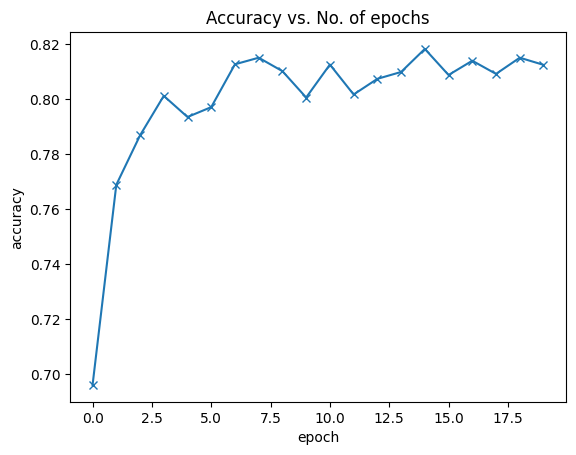

In [96]:
model = to_device(Cifar10CnnModel4(), device)
evaluate(model, val_dl)

# Count the total number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Total number of parameters: ", total_params)

num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001

history4 = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)
plot_accuracies(history4)

## Model #05

In [97]:
class Cifar10CnnModel5(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, xb):
        return self.network(xb)


Total number of parameters:  5853066
Epoch [0], train_loss: 1.2173, val_loss: 0.8885, val_acc: 0.6879
Epoch [1], train_loss: 0.7320, val_loss: 0.6938, val_acc: 0.7616
Epoch [2], train_loss: 0.5374, val_loss: 0.6490, val_acc: 0.7879
Epoch [3], train_loss: 0.4061, val_loss: 0.5901, val_acc: 0.8115
Epoch [4], train_loss: 0.2994, val_loss: 0.5606, val_acc: 0.8285
Epoch [5], train_loss: 0.2179, val_loss: 0.7068, val_acc: 0.8065
Epoch [6], train_loss: 0.1677, val_loss: 0.6754, val_acc: 0.8259
Epoch [7], train_loss: 0.1325, val_loss: 0.7437, val_acc: 0.8263
Epoch [8], train_loss: 0.1135, val_loss: 0.7993, val_acc: 0.8279
Epoch [9], train_loss: 0.0939, val_loss: 0.8048, val_acc: 0.8292
Epoch [10], train_loss: 0.0872, val_loss: 0.8414, val_acc: 0.8247
Epoch [11], train_loss: 0.0768, val_loss: 0.8627, val_acc: 0.8272
Epoch [12], train_loss: 0.0746, val_loss: 0.8547, val_acc: 0.8371
Epoch [13], train_loss: 0.0665, val_loss: 0.8822, val_acc: 0.8247
Epoch [14], train_loss: 0.0677, val_loss: 0.8206,

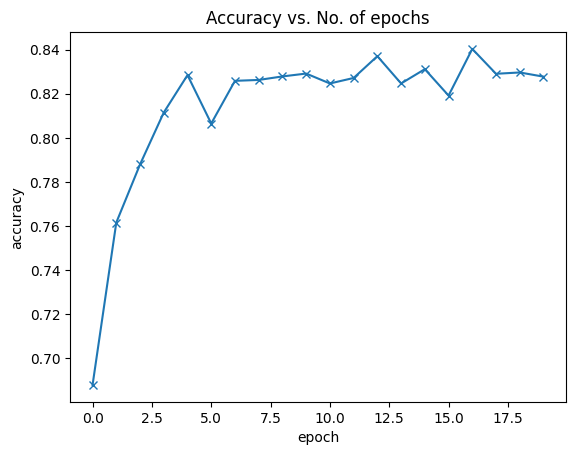

In [98]:
model = to_device(Cifar10CnnModel3(), device)
evaluate(model, val_dl)

# Count the total number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Total number of parameters: ", total_params)

num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001

history5 = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)
plot_accuracies(history5)

## Model Comparison

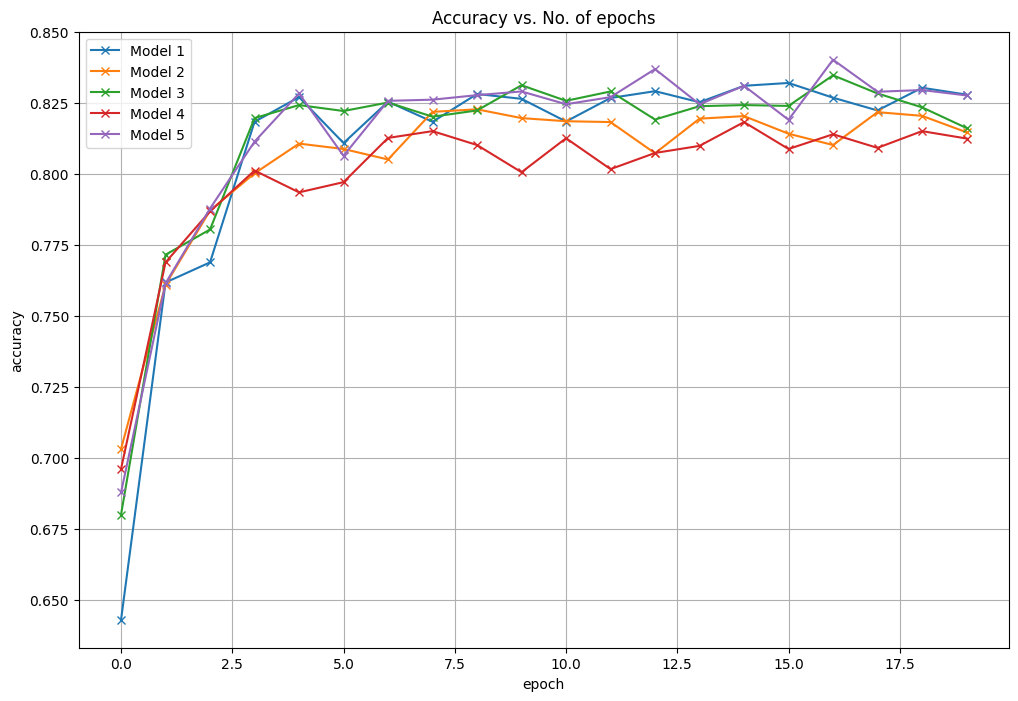

In [104]:
def plot_accuracies(history, model_name):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x', label=model_name)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.legend()
    plt.grid(True)
    plt.rcParams['figure.figsize'] = [18, 12]  # Increase plot size to width=18, height=12

plot_accuracies(history1, 'Model 1')
plot_accuracies(history2, 'Model 2')
plot_accuracies(history3, 'Model 3')
plot_accuracies(history4, 'Model 4')
plot_accuracies(history5, 'Model 5')
